In [40]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

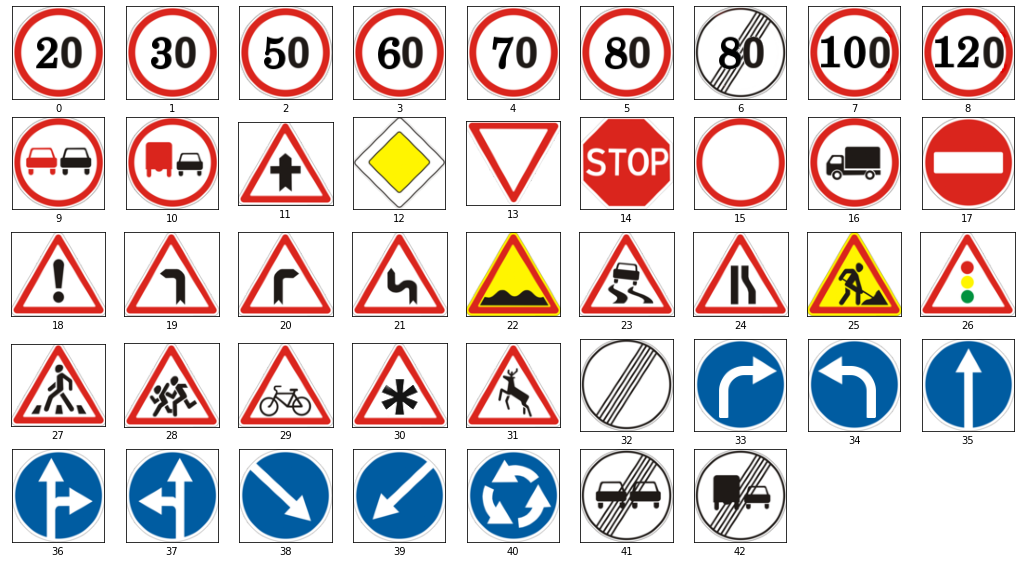

In [15]:
# Here is the meta files on the 43 seperate traffic sign classes we are learning to identify 
plt.figure(figsize=(18, 18))
for i in range (0,43):
    plt.subplot(9,9,i+1)
    plt.xticks([])
    plt.yticks([])
    path = "./Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

In [16]:
for i in range (0,43):
    path, dirs, files = next(os.walk(f"./Train/{i}"))
    file_count = len(files)
    print(f"Files for class {i}: {file_count}")

Files for class 0: 210
Files for class 1: 2220
Files for class 2: 2250
Files for class 3: 1410
Files for class 4: 1980
Files for class 5: 1860
Files for class 6: 420
Files for class 7: 1440
Files for class 8: 1410
Files for class 9: 1470
Files for class 10: 2010
Files for class 11: 1320
Files for class 12: 2100
Files for class 13: 2160
Files for class 14: 780
Files for class 15: 630
Files for class 16: 420
Files for class 17: 1110
Files for class 18: 1200
Files for class 19: 210
Files for class 20: 360
Files for class 21: 330
Files for class 22: 390
Files for class 23: 510
Files for class 24: 270
Files for class 25: 1500
Files for class 26: 600
Files for class 27: 240
Files for class 28: 540
Files for class 29: 270
Files for class 30: 450
Files for class 31: 780
Files for class 32: 240
Files for class 33: 689
Files for class 34: 420
Files for class 35: 1200
Files for class 36: 390
Files for class 37: 210
Files for class 38: 2070
Files for class 39: 300
Files for class 40: 360
Files for

In [17]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [21]:
dir = "."
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  32.23821401596069


In [54]:
train_image_data = pd.read_csv('Train.csv')
test_image_data = pd.read_csv('Test.csv')

In [57]:
train_image_data.describe()
test_image_data.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


<AxesSubplot:>

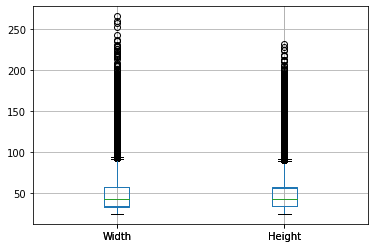

In [55]:
train_image_data.boxplot(['Width', 'Height'])

<AxesSubplot:>

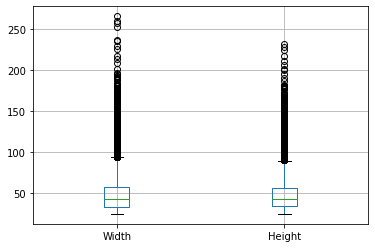

In [56]:
test_image_data.boxplot(['Width', 'Height'])

In [60]:
classes = 43
batch = 256
epochs = 3
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

80142336/80134624 [==============================] - 9s 0us/step
Epoch 1/3
123/123 [==============================] - 1138s 9s/step - loss: 0.9989 - accuracy: 0.7815 - val_loss: 0.9582 - val_accuracy: 0.9827
Epoch 2/3
123/123 [==============================] - 1104s 9s/step - loss: 0.0711 - accuracy: 0.9905 - val_loss: 0.2398 - val_accuracy: 0.9944
Epoch 3/3
123/123 [==============================] - 1019s 8s/step - loss: 0.0228 - accuracy: 0.9973 - val_loss: 0.0576 - val_accuracy: 0.9938
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
________________________

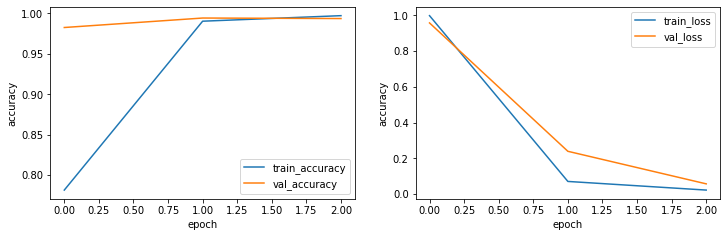

In [61]:
model = Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)

In [62]:
model

In [64]:
  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
#   print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

395/395 [==============================] - 77s 196ms/step - loss: 0.1768 - accuracy: 0.9618
Test accuracy: 0.9617577195167542
Test loss: 0.17679448425769806
Test time:  77.60471200942993
